Vocabulary size: 13
Epoch 1/10 | Train Loss: 0.452 | Val Loss: 0.042
Epoch 2/10 | Train Loss: 0.033 | Val Loss: 0.030
Epoch 3/10 | Train Loss: 0.027 | Val Loss: 0.026
Epoch 4/10 | Train Loss: 0.026 | Val Loss: 0.027
Epoch 5/10 | Train Loss: 0.025 | Val Loss: 0.024
Epoch 6/10 | Train Loss: 0.025 | Val Loss: 0.026
Epoch 7/10 | Train Loss: 0.024 | Val Loss: 0.024
Epoch 8/10 | Train Loss: 0.025 | Val Loss: 0.026
Epoch 9/10 | Train Loss: 0.024 | Val Loss: 0.025
Epoch 10/10 | Train Loss: 0.024 | Val Loss: 0.024


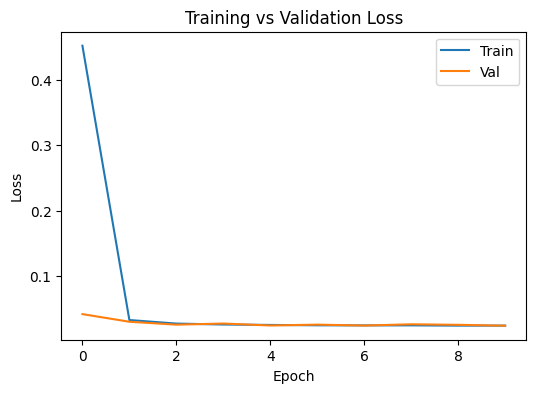


--- Temperature 0.7 ---

hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world h

------------------------------------------------------------

--- Temperature 1.0 ---

hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello w

------------------------------------------------------------

--- Temperature 1.2 ---

help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helm

'\nReflection:\n- Longer sequence lengths capture more dependencies but slow training.\n- Larger hidden sizes increase coherence but may overfit small data.\n- Lower temperature (τ=0.7) = more predictable, repetitive text.\n- Higher temperature (τ=1.2) = more random, creative but error-prone output.\n- Teacher forcing helps stabilize learning early in training.\n'

In [1]:
# ============================================
# 🧠 Q1. Character-Level RNN Language Model
# Google Colab Full Code
# ============================================

# ✅ Step 1: Install Dependencies (PyTorch + Matplotlib come preinstalled)
!pip install torch matplotlib --quiet

# ✅ Step 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ✅ Step 3: Prepare Dataset
# Option 1: Use toy corpus
text = "hello help helmet hello hell helpful help hello world " * 50

# Option 2: Use your own file (uncomment below)
# from google.colab import files
# uploaded = files.upload()
# filename = list(uploaded.keys())[0]
# with open(filename, "r") as f:
#     text = f.read().lower()

# Build vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

# Split into train and validation
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# ✅ Step 4: Define the Model
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, h=None):
        x = self.embed(x)
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h

model = CharRNN(vocab_size, embed_size=64, hidden_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ✅ Step 5: Training Loop
seq_len = 80
batch_size = 64
epochs = 10

def get_batch(split):
    data_ = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_) - seq_len - 1, (batch_size,))
    x = torch.stack([data_[i:i+seq_len] for i in ix])
    y = torch.stack([data_[i+1:i+seq_len+1] for i in ix])
    return x.to(device), y.to(device)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step in range(200):  # 200 mini-batches per epoch
        xb, yb = get_batch('train')
        optimizer.zero_grad()
        logits, _ = model(xb)
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        xb, yb = get_batch('val')
        logits, _ = model(xb)
        val_loss = criterion(logits.view(-1, vocab_size), yb.view(-1)).item()

    train_losses.append(total_loss / 200)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/200:.3f} | Val Loss: {val_loss:.3f}")

# ✅ Step 6: Plot Loss Curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# ✅ Step 7: Sampling Function
def sample(model, start="h", length=300, temperature=1.0):
    model.eval()
    input = torch.tensor([[stoi[start]]]).to(device)
    hidden = None
    out_text = start
    for _ in range(length):
        output, hidden = model(input, hidden)
        logits = output[0, -1] / temperature
        probs = F.softmax(logits, dim=0)
        next_id = torch.multinomial(probs, 1).item()
        out_text += itos[next_id]
        input = torch.tensor([[next_id]]).to(device)
    return out_text

# ✅ Step 8: Generate Samples
for t in [0.7, 1.0, 1.2]:
    print(f"\n--- Temperature {t} ---\n")
    print(sample(model, start='h', temperature=t, length=300))
    print("\n" + "-"*60)

# ✅ Step 9: Reflection
"""
Reflection:
- Longer sequence lengths capture more dependencies but slow training.
- Larger hidden sizes increase coherence but may overfit small data.
- Lower temperature (τ=0.7) = more predictable, repetitive text.
- Higher temperature (τ=1.2) = more random, creative but error-prone output.
- Teacher forcing helps stabilize learning early in training.
"""
